In [14]:
#import solver related modules
from MCEq.core import MCEqRun
import mceq_config as config
#import primary model choices
import crflux.models as pm
import matplotlib.pylab as plt
import numpy as np

In [15]:
config.enable_2D = True
config.mceq_db_fname = 'mceq_db_rare_decays_URQMD_lext_2D.h5'
config.enable_default_tracking = False
config.enable_em = False
config.enable_em_ion = False
config.hybrid_crossover = 0.1
config.muon_energy_loss = True
config.enable_cont_rad_loss = True
config.enable_energy_loss = True
config.muon_helicity_dependence = True
config.density_model = ("CORSIKA", ("USStd", None))

config.adv_set['force_resonance'] = [421, 431, 411, 310]
config.adv_set['disabled_particles'] = [22, 111, 16, 11]

mceq_run = MCEqRun(
        #provide the string of the interaction model
        interaction_model="EPOS-LHC",
        #primary cosmic ray flux model
        primary_model = (pm.HillasGaisser2012, "H3a"),
        # Zenith angle in degrees. 0=vertical, 90=horizontal
        theta_deg=30.0,
        density_model = ("CORSIKA", ("USStd", None))
    )

MCEqRun::set_interaction_model(): EPOSLHC
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('USStd', None)
MCEqRun::set_primary_model(): Primary model set to Hillas-Gaisser (H3a)


In [16]:
slant_depth = 143

if mceq_run.density_model.max_X < slant_depth:
            raise ValueError(f"Maximum slant_xdepth = {mceq_run.density_model.max_X}")

#Set the zenith angle
mceq_run.set_theta_deg(30)
mceq_run.set_single_primary_particle(100, pdg_id = 2212)
mceq_run.solve(int_grid=[slant_depth])

100%|██████████| 2559/2559 [00:19<00:00, 129.17it/s]


In [17]:
# part_long_spectra = {}
# for p in mceq_run.pman.all_particles:
#     # print(f"Spectrum for {p.name}")
#     try: 
#         part_long_spectra[p.name] = mceq_run.get_solution(p.name, grid_idx=0)
#     except Exception as ex:
#         pass
#         # print(ex) 

In [110]:
hank_trans_res = []

part_tuple = [(-13, 0), (-13, -1), (-13, 1), (13, 0), (13, -1), (13, 1)]
# part_tuple = [(-14, 0), (14, 0)]

for part in part_tuple:
    hank_trans_res.append(mceq_run.convert_to_theta_space(
        mceq_run.grid_sol, *part))


In [111]:

ang_grid = hank_trans_res[0][2]
ang_dists = [None for i in range(51)]

for i_energy in range(51):
    for res in hank_trans_res:
        if ang_dists[i_energy] is None:
            ang_dists[i_energy] = res[3][0][i_energy]
        else:
            ang_dists[i_energy] += res[3][0][i_energy]
 
# ang_dists_dt is dN/dE (t*dt), where t is angle.
ang_dists = np.array(ang_dists)
# We multiply it to angle to get dN/dEdt        
ang_dists_t = ang_dists*ang_grid[np.newaxis, :]        

In [112]:
ang_bins_deg = np.linspace(0, 90, 91)
ang_bins = np.deg2rad(ang_bins_deg)
ang_cent = (ang_bins[1:] + ang_bins[:-1])/2
ang_delt = ang_bins[1:] - ang_bins[:-1]

In [113]:
from scipy.interpolate import interp1d

dist_at_ang_cent = [None for i in range(51)]
for i, ang_dist in enumerate(ang_dists):
    dist_at_ang_cent[i] = interp1d(ang_grid, ang_dist)(ang_cent)
    
    
dist_at_ang_cent = np.array(dist_at_ang_cent)   

In [68]:
ang_grid[100]

0.2622364485467273

In [69]:
mceq_run.e_grid[25]

28.183829312644548

In [147]:
from scipy.interpolate import interp1d
from scipy.interpolate import RectBivariateSpline
from scipy.integrate import nquad

def get_spline_2Dfunction(energy_grid, angle_grid, dist_function):
    # Create a spline representation of the input data
    spline = RectBivariateSpline(energy_grid, angle_grid, dist_function, kx = 5, ky = 5)
    
    # Define the 2D distribution function
    def distribution_function(energy, angle):
        return spline.ev(energy, angle)
    
    return distribution_function

def get_histogram(energy_bins, angle_bins, distribution_function):
    
    # distribution_function is assumed to be dN/(dE d(theta))
    
    # Initialize the histogram values to zero
    hist = np.zeros((len(energy_bins) - 1, len(angle_bins) - 1))

    # Integrate the distribution function in each bin
    for i in range(len(energy_bins) - 1):
        energy_start = energy_bins[i]
        energy_end = energy_bins[i+1]
        for j in range(len(angle_bins) - 1):
            angle_start = angle_bins[j]
            angle_end = angle_bins[j+1]
            hist[i,j], _ = nquad(distribution_function, 
                                 [(energy_start, energy_end), (angle_start, angle_end)])
            
    
    return hist      

In [155]:
len(mceq_run.e_grid)

51

In [148]:
sp_func = get_spline_2Dfunction(mceq_run.e_grid, ang_grid, ang_dists_t)

dist_hist = get_histogram(mceq_run.e_bins, ang_bins, sp_func)
# dist_hist = np.exp(dist_hist)

In [116]:
res_hists = ((dist_at_ang_cent * mceq_run.e_widths[:, np.newaxis])
*ang_cent_delt[np.newaxis, :])

In [117]:
dist_at_ang_cent[:]*mceq_run.e_widths

ValueError: operands could not be broadcast together with shapes (51,90) (51,) 

In [10]:
np.where((mceq_run.e_grid >= 1.0) & (mceq_run.e_grid <= 1.3))[0]
# 11, 14, 17

array([11])

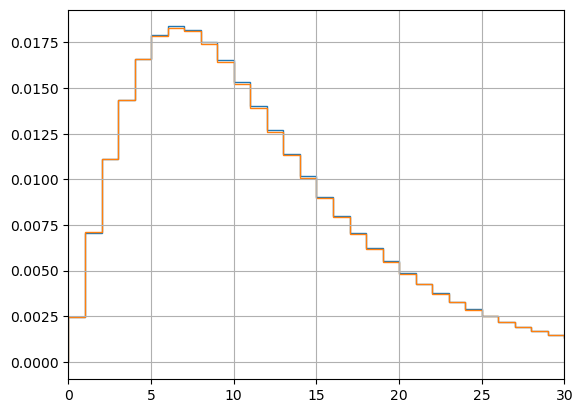

In [154]:
mceq_run.e_bins

plt.stairs(res_hists[11], ang_bins_deg)
plt.stairs(dist_hist[11], ang_bins_deg)
# plt.scale("log")
# plt.stairs(res_hists[14], ang_bins_deg)
# plt.stairs(res_hists[17], ang_bins_deg)

# plt.stairs(dist_hist[11], ang_bins_deg)
# plt.stairs(dist_hist[14], ang_bins_deg)
# plt.stairs(dist_hist[17], ang_bins_deg)

# plt.stairs((dist_at_ang_cent[11]*mceq_run.e_widths[11]
#             *ang_cent * ang_delt),
#     np.rad2deg(ang_bins))

# plt.stairs((dist_at_ang_cent[11]*mceq_run.e_widths[11]
#             *np.sin(ang_cent) * ang_delt),
#     np.rad2deg(ang_bins))

# plt.stairs((np.sin(ang_cent)/ang_cent),
#     np.rad2deg(ang_bins))

# plt.stairs((dist_at_ang_cent[14]*mceq_run.e_widths[14]
#             *ang_cent * ang_delt),
#     np.rad2deg(ang_bins))

# plt.stairs((dist_at_ang_cent[17]*mceq_run.e_widths[17]
#             *ang_cent * ang_delt),
#     np.rad2deg(ang_bins))

# plt.stairs((dist_at_ang_cent[0][14]*
#             mceq_run.e_widths[14]*np.sin(ang_cent)),
#     np.rad2deg(ang_bins))

# plt.stairs((dist_at_ang_cent[0][17]*
#             mceq_run.e_widths[17]*np.sin(ang_cent)),
#     np.rad2deg(ang_bins))


# plt.stairs((dist_at_ang_cent[0][11]*(1.3 - 1)*ang_cent*ang_delt),
#     np.rad2deg(ang_bins))

# plt.stairs((dist_at_ang_cent[0][14]*(2.5 - 2.0)*ang_cent*ang_delt),
#     np.rad2deg(ang_bins))

# plt.stairs((dist_at_ang_cent[0][17]*(5.0 - 4.0)*ang_cent*ang_delt),
#     np.rad2deg(ang_bins))

# plt.stairs(store_inverse_hankel_transfs[0][11],
#     np.rad2deg(theta_bins))

plt.xlim(0, 30)
# plt.yticks(np.linspace(0, 1.5e-2, 4))
# plt.ylim(0.99, 1.008)
plt.grid()

In [153]:
dist_hist[20]

array([ 3.46492506e-02,  6.21285752e-02,  4.30434480e-02,  2.22915765e-02,
        1.05998867e-02,  4.89318647e-03,  2.37625036e-03,  1.10363839e-03,
        5.49376368e-04,  3.34322946e-04,  1.18342856e-04,  4.11305600e-05,
        4.45022159e-05,  3.76140575e-05,  9.09971813e-06,  7.59304305e-07,
       -3.51288900e-06, -1.14191456e-05, -3.48925860e-06,  5.19162241e-08,
        2.48265131e-06,  3.24796183e-06, -2.22983176e-06, -1.17824924e-05,
       -1.34891158e-05, -7.88725651e-06, -4.82222022e-06, -1.51404047e-06,
       -4.04761230e-08, -1.10126662e-06, -3.32691629e-06, -5.63879511e-06,
       -8.54223388e-06, -1.00768948e-05, -9.19690069e-06, -8.83974352e-06,
       -7.74960332e-06, -5.91056267e-06, -4.84347437e-06, -5.36120533e-06,
       -6.31179749e-06, -7.23959580e-06, -8.03190687e-06, -7.92718093e-06,
       -8.23486180e-06, -8.83182432e-06, -9.18590398e-06, -9.44354389e-06,
       -9.85398039e-06, -9.89132759e-06, -9.45193063e-06, -9.31358246e-06,
       -9.24359779e-06, -

In [151]:
res_hists[20]

array([ 3.70838604e-02,  6.46426772e-02,  4.32069013e-02,  2.18978572e-02,
        1.02856267e-02,  4.68657433e-03,  2.28518830e-03,  1.03298164e-03,
        5.14089781e-04,  3.24764878e-04,  1.01714712e-04,  3.32448085e-05,
        4.15811296e-05,  3.77883795e-05,  7.37193884e-06,  8.65757117e-07,
       -3.15217560e-06, -1.29298593e-05, -3.14730931e-06, -1.73576593e-08,
        2.76373539e-06,  3.69410113e-06, -1.95892592e-06, -1.22376424e-05,
       -1.39948549e-05, -7.70897207e-06, -4.88425378e-06, -1.33926515e-06,
        1.17498062e-07, -1.06210503e-06, -3.39078303e-06, -5.59397783e-06,
       -8.57677244e-06, -1.01722155e-05, -9.08012259e-06, -8.83893418e-06,
       -7.71512884e-06, -5.83819936e-06, -4.74840495e-06, -5.39830669e-06,
       -6.40198025e-06, -7.33059809e-06, -8.17683518e-06, -7.91712619e-06,
       -8.19385192e-06, -8.77807541e-06, -9.12475404e-06, -9.38733935e-06,
       -9.85901987e-06, -9.93821137e-06, -9.47486463e-06, -9.37772853e-06,
       -9.29030596e-06, -

In [30]:
len(hank_trans)

4

In [35]:
len(hank_trans[0])

10000

In [10]:
mceq_run.get_solution("mu+", grid_idx=0)

ValueError: operands could not be broadcast together with shapes (51,) (0,1071) (51,) 

In [22]:
solutions = mceq_run._solution

In [25]:
solutions.shape

(24, 1071)

In [19]:
for i, solution in enumerate(solutions):
    print(i, len(solution))
    for sl in solution:
        print(len(sl))

0 1071


TypeError: object of type 'numpy.float64' has no len()

In [9]:
print(part_long_spectra.keys())

dict_keys([])


In [5]:
a_mat = np.array([[1, 1], [1, 1]])

In [6]:
bm = np.array([3,5])


In [8]:
a_mat*bm[:, np.newaxis]

array([[3, 3],
       [5, 5]])

In [9]:
bm[:, np.newaxis]

array([[3],
       [5]])

In [13]:
a_mat

array([[1, 1],
       [1, 1]])

In [11]:
a_mat*bm[np.newaxis, :]

array([[3, 5],
       [3, 5]])

In [12]:
bm[np.newaxis, :]

array([[3, 5]])

In [49]:
x = np.linspace(-5, 5, 10)
y = np.linspace(-1, 1, 5)
X, Y = np.meshgrid(x, y, indexing='ij')

In [50]:
X

array([[-5.        , -5.        , -5.        , -5.        , -5.        ],
       [-3.88888889, -3.88888889, -3.88888889, -3.88888889, -3.88888889],
       [-2.77777778, -2.77777778, -2.77777778, -2.77777778, -2.77777778],
       [-1.66666667, -1.66666667, -1.66666667, -1.66666667, -1.66666667],
       [-0.55555556, -0.55555556, -0.55555556, -0.55555556, -0.55555556],
       [ 0.55555556,  0.55555556,  0.55555556,  0.55555556,  0.55555556],
       [ 1.66666667,  1.66666667,  1.66666667,  1.66666667,  1.66666667],
       [ 2.77777778,  2.77777778,  2.77777778,  2.77777778,  2.77777778],
       [ 3.88888889,  3.88888889,  3.88888889,  3.88888889,  3.88888889],
       [ 5.        ,  5.        ,  5.        ,  5.        ,  5.        ]])

In [51]:
Y

array([[-1. , -0.5,  0. ,  0.5,  1. ],
       [-1. , -0.5,  0. ,  0.5,  1. ],
       [-1. , -0.5,  0. ,  0.5,  1. ],
       [-1. , -0.5,  0. ,  0.5,  1. ],
       [-1. , -0.5,  0. ,  0.5,  1. ],
       [-1. , -0.5,  0. ,  0.5,  1. ],
       [-1. , -0.5,  0. ,  0.5,  1. ],
       [-1. , -0.5,  0. ,  0.5,  1. ],
       [-1. , -0.5,  0. ,  0.5,  1. ],
       [-1. , -0.5,  0. ,  0.5,  1. ]])